# CCAPS Distress Outcome Predictor:  Machine Learning Model Development

### Import necessary packages

In [1]:
import os
import csv
import re
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

### Read and store .csv file containing CCAPS data.  

This .csv file has been manually sorted according to date (ascending) and CCAPSClientID.  The sorting was expanded to preserve all rows' original positions.  It contains approximately 33 months of CCAPS data from CAPS at Liberty University.

In [2]:
pre_post = pd.read_csv('CCAPS-62 Export for 2021-08-16 to 2024-05-10.csv')
pre_post = pre_post[['CCAPSClientID', 'Distress_Index']]
#Showing only clientID and Distress_Index columns
pre_post

,CCAPSClientID,Distress_Index
0,643590,1.80
1,643590,1.75
2,643635,1.80
3,643635,1.20
4,643635,0.35
...,...,...
6130,1130103,2.45
6131,1130209,2.45
6132,1131252,1.95
6133,1131299,2.55


### Remove single CCAPS instances and create new dataframe containing students with more than one CCAPS.
### Ensure there is a pre- and post-treatment CCAPS for each student in this dataframe.

In [3]:
pre_post = pre_post[pre_post.duplicated(subset = ['CCAPSClientID'], keep=False)]
pre_post

,CCAPSClientID,Distress_Index
0,643590,1.80
1,643590,1.75
2,643635,1.80
3,643635,1.20
4,643635,0.35
...,...,...
6110,1125838,0.90
6111,1126127,2.15
6112,1126127,2.20
6118,1126590,2.95


In [4]:
#Are there conveniently an even number of duplicates for every student?  Find out by creating a pivot table.
dup_counts = pre_post.pivot_table(index = ['CCAPSClientID'], aggfunc='size')
dup_counts.to_csv('duplicate_counts.csv')

dup_counts_df = pd.DataFrame(dup_counts)
dup_counts_df

#No, there are some with odd numbers of duplicates.  Create a dataframe that lists all the ClientIDs with even numbers of ccaps.
dup_counts_df = dup_counts_df.drop(dup_counts_df[dup_counts_df[0] % 2 != 0].index)
dup_counts_df.reset_index(inplace=True)
print(dup_counts_df)

#now iterate through this list and if the client ID in the dataset matches the ClientID here, keep it; otherwise, drop it.
ccaps_id_lst = []
for i in dup_counts_df['CCAPSClientID']:
    ccaps_id_lst.append(i)

#this is the new dataframe that includes only ccapsIDs with an even number of CCAPS.
pre_post_2 = pre_post[pre_post.CCAPSClientID.isin(ccaps_id_lst)]
print(pre_post_2)
        

      CCAPSClientID  0
0            643590  2
1            643635  6
2            643679  4
3            643703  2
4            643784  4
...             ... ..
1363        1125446  2
1364        1125461  2
1365        1125838  2
1366        1126127  2
1367        1126590  2

[1368 rows x 2 columns]
      CCAPSClientID  Distress_Index
0            643590            1.80
1            643590            1.75
2            643635            1.80
3            643635            1.20
4            643635            0.35
...             ...             ...
6110        1125838            0.90
6111        1126127            2.15
6112        1126127            2.20
6118        1126590            2.95
6119        1126590            2.15

[3466 rows x 2 columns]


# Target Data

### Start with row one (the first duplicate), and every other row will be a follow-up CCAPS because there is an even number for each student and they are arranged by date.

In [5]:
#Print a list of clients' post-treatment Distress Index scores,
exit_DI = pre_post_2[1::2]
exit_DI

,CCAPSClientID,Distress_Index
1,643590,1.75
3,643635,1.20
5,643635,0.40
7,643635,0.00
9,643679,1.15
...,...,...
6102,1125446,1.55
6106,1125461,0.10
6110,1125838,0.90
6112,1126127,2.20


In [6]:
# Explore datatypes in this dataframe.
exit_DI.dtypes

CCAPSClientID       int64
Distress_Index    float64
dtype: object

In [7]:
#change the CCAPSClientID column data to string data so it won't be manipulated by numerical operations.
exit_DI['CCAPSClientID'] = exit_DI['CCAPSClientID'].astype(str)

C:\Users\JCross\AppData\Local\Temp\ipykernel_6616\443771644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_DI['CCAPSClientID'] = exit_DI['CCAPSClientID'].astype(str)


In [8]:
# Re-check data types.
exit_DI.dtypes

CCAPSClientID      object
Distress_Index    float64
dtype: object

In [9]:
exit_DI['Distress_Index']

1       1.75
3       1.20
5       0.40
7       0.00
9       1.15
        ... 
6102    1.55
6106    0.10
6110    0.90
6112    2.20
6119    2.15
Name: Distress_Index, Length: 1733, dtype: float64

### Categorize Target Data as Low, Medium, or High
The cut scores for the categories were derived from the CCAPS 2021 Manual (pp. 14, 23).

In [10]:
# First get rid of any 0.00 values by replacing with a negligible flooat value.
mask = exit_DI['Distress_Index'] == 0.00
exit_DI.loc[mask, 'Distress_Index'] = 0.00001
# Now categorize
exit_DI.loc[:, 'Categories'] = pd.cut(x = exit_DI['Distress_Index'], bins = [-0.01, 1.30, 2.24, 4.0], labels = ['Low', 'Moderate', 'High'])
exit_DI

C:\Users\JCross\AppData\Local\Temp\ipykernel_6616\298204848.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_DI.loc[:, 'Categories'] = pd.cut(x = exit_DI['Distress_Index'], bins = [-0.01, 1.30, 2.24, 4.0], labels = ['Low', 'Moderate', 'High'])


,CCAPSClientID,Distress_Index,Categories
1,643590,1.75000,Moderate
3,643635,1.20000,Low
5,643635,0.40000,Low
7,643635,0.00001,Low
9,643679,1.15000,Low
...,...,...,...
6102,1125446,1.55000,Moderate
6106,1125461,0.10000,Low
6110,1125838,0.90000,Low
6112,1126127,2.20000,Moderate


In [11]:
#View more rows of the dataframe to ensure functionality.
exit_DI.head(25)

,CCAPSClientID,Distress_Index,Categories
1,643590,1.75000,Moderate
3,643635,1.20000,Low
5,643635,0.40000,Low
7,643635,0.00001,Low
9,643679,1.15000,Low
11,643679,1.00000,Low
13,643703,2.10000,Moderate
15,643784,2.05000,Moderate
17,643784,2.20000,Moderate
19,643841,1.50000,Moderate


### View the number of clients per category

In [12]:
exit_DI['Categories'].value_counts()

Categories
Low         1124
Moderate     456
High         152
Name: count, dtype: int64

### Store these post-treatment distress index categories as the target (this is what we are training the model to predict).

In [13]:
target = exit_DI['Categories']

# Feature Data
Features are what the machine learning model considers as variables that influence the target.  Here, the features are being identified and stored.  The features data are being extracted from a .csv file containing approximately 33 months worth of CCAPS data.

In [14]:
# Use pandas to read the .csv and translate to a dataframe.
CCAPS_data = pd.read_csv('CCAPS-62 Export for 2021-08-16 to 2024-05-10.csv')
CCAPS_df = pd.DataFrame(CCAPS_data)

In [15]:
#keep only repeat CCAPS in the dataframe.  The pre-treatment CCAPS subscales are our features.
ccaps_features = CCAPS_df[CCAPS_df.duplicated(subset = ['CCAPSClientID'], keep=False)]

In [16]:
#make sure there exists only repeats in multiples of 2
duplicate_counts = ccaps_features.pivot_table(index = ['CCAPSClientID'], aggfunc='size')
duplicate_counts.to_csv('duplicate_counts.csv')

duplicate_counts_df = pd.DataFrame(duplicate_counts)
duplicate_counts_df

#No, there are some with odd numbers of duplicates.  Create a dataframe that lists all the ClientIDs with even numbers of ccaps.
duplicate_counts_df = duplicate_counts_df.drop(duplicate_counts_df[duplicate_counts_df[0] % 2 != 0].index)
duplicate_counts_df.reset_index(inplace=True)


#now iterate through this list and if the client ID in the dataset matches the ClientID here, keep it; otherwise, drop it.
ccaps_ids_lst = []
for i in duplicate_counts_df['CCAPSClientID']:
    ccaps_ids_lst.append(i)

#this is the new dataframe that includes only ccapsIDs with an even number of CCAPS.
ccaps_features = ccaps_features[ccaps_features.CCAPSClientID.isin(ccaps_ids_lst)]


### Keep only the first entry from each set of CCAPS, using only the entrance CCAPS to predict the exit distress index. 

In [17]:
ccaps_features = ccaps_features[0::2]
#View columns to ensure all features are present.
ccaps_features.columns

Index(['CCAPSClientID', 'Date', 'CCAPS_01', 'CCAPS_03', 'CCAPS_04', 'CCAPS_05',
       'CCAPS_06', 'CCAPS_08', 'CCAPS_09', 'CCAPS_10', 'CCAPS_11', 'CCAPS_13',
       'CCAPS_14', 'CCAPS_15', 'CCAPS_16', 'CCAPS_17', 'CCAPS_18', 'CCAPS_19',
       'CCAPS_21', 'CCAPS_22', 'CCAPS_23', 'CCAPS_24', 'CCAPS_25', 'CCAPS_26',
       'CCAPS_27', 'CCAPS_28', 'CCAPS_29', 'CCAPS_30', 'CCAPS_31', 'CCAPS_32',
       'CCAPS_33', 'CCAPS_34', 'CCAPS_35', 'CCAPS_36', 'CCAPS_37', 'CCAPS_38',
       'CCAPS_39', 'CCAPS_40', 'CCAPS_41', 'CCAPS_43', 'CCAPS_44', 'CCAPS_45',
       'CCAPS_46', 'CCAPS_47', 'CCAPS_48', 'CCAPS_49', 'CCAPS_50', 'CCAPS_51',
       'CCAPS_52', 'CCAPS_53', 'CCAPS_54', 'CCAPS_56', 'CCAPS_57', 'CCAPS_58',
       'CCAPS_59', 'CCAPS_60', 'CCAPS_61', 'CCAPS_63', 'CCAPS_64', 'CCAPS_65',
       'CCAPS_66', 'CCAPS_68', 'CCAPS_69', 'CCAPS_70', 'Depression',
       'Generalized_Anxiety', 'Social_Anxiety', 'Academic_Distress',
       'Eating_Concerns', 'Frustration_Anger', 'Family_Distress',
     

In [18]:
#keep only the features. We will use all eight of these subscales as features even though CCAPS derives their Distress Index by only these five:  Depression, Gen Anx, Soc Anx, Academic Distress, and Frustration/Anger.
ccaps_features = ccaps_features[['CCAPSClientID', 'Date', 'Depression', 'Generalized_Anxiety', 'Social_Anxiety', 'Academic_Distress', 'Eating_Concerns', 'Frustration_Anger', 'Family_Distress', 'Substance_Use', 'Thoughts_of_Hurting_Others', 'Suicide_Index']]

In [19]:
ccaps_features

,CCAPSClientID,Date,Depression,Generalized_Anxiety,Social_Anxiety,Academic_Distress,Eating_Concerns,Frustration_Anger,Family_Distress,Substance_Use,Thoughts_of_Hurting_Others,Suicide_Index
0,643590,8/25/2022 0:00,1.153846,2.888889,1.571429,1.6,0.888889,1.142857,1.666667,0.0,0.0,0.0
2,643635,8/23/2021 0:00,1.538462,2.555556,2.857143,0.6,0.111111,0.571429,0.000000,0.0,0.0,3.0
4,643635,9/29/2023 0:00,0.230769,0.777778,1.571429,0.4,0.222222,0.428571,0.000000,0.0,0.0,0.0
6,643635,1/18/2024 0:00,0.461538,0.666667,1.428571,0.0,0.222222,0.000000,0.000000,0.0,0.0,0.0
8,643679,8/23/2021 0:00,1.384615,1.777778,2.857143,0.2,2.888889,0.428571,2.833333,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6101,1125446,4/12/2024 0:00,2.384615,2.000000,2.857143,1.0,1.222222,1.142857,1.833333,0.0,0.0,1.0
6105,1125461,4/12/2024 0:00,0.846154,2.111111,1.000000,0.8,0.111111,0.142857,0.000000,0.0,0.0,0.0
6109,1125838,4/15/2024 0:00,1.076923,1.222222,1.571429,2.8,1.222222,0.857143,1.166667,0.0,0.0,0.0
6111,1126127,4/15/2024 0:00,2.230769,2.333333,3.857143,0.8,1.555556,0.428571,1.333333,0.0,0.0,0.0


# Machine Learning

In [20]:
# Setup matplotlib to plot inline (within the notebook)
%matplotlib inline

# Import the pyplot module of Matplotlib as plt
import matplotlib.pyplot as plt

# Import pandas under the abbreviation 'pd'
import pandas as pd

# Import NumPy under the abbreviation 'np'
import numpy as np

### Create X (features) and y (target)
Create X (features).  ID numbers and date are excluded here because they are not Machine Learning (ML) features.

In [21]:
# Create X.
X = ccaps_features.iloc[:, 2:12]
print(X.head())

# Find null feature values (if any) and replace with zero.
print(X.isna().sum())
X = X.fillna(0)
print(X.isna().sum())

# Create y (outcomes).  
y = target
y = y.fillna('Moderate')
print(y.isna().sum())

   Depression  Generalized_Anxiety  Social_Anxiety  Academic_Distress  \
0    1.153846             2.888889        1.571429                1.6   
2    1.538462             2.555556        2.857143                0.6   
4    0.230769             0.777778        1.571429                0.4   
6    0.461538             0.666667        1.428571                0.0   
8    1.384615             1.777778        2.857143                0.2   

   Eating_Concerns  Frustration_Anger  Family_Distress  Substance_Use  \
0         0.888889           1.142857         1.666667            0.0   
2         0.111111           0.571429         0.000000            0.0   
4         0.222222           0.428571         0.000000            0.0   
6         0.222222           0.000000         0.000000            0.0   
8         2.888889           0.428571         2.833333            0.0   

   Thoughts_of_Hurting_Others  Suicide_Index  
0                         0.0            0.0  
2                         0.

### Train the Machine Learning Model

In [22]:
# Import train_test_split from sklearn's model_selection module
from sklearn.model_selection import train_test_split

# Use train_test_split to split X & y into training and test sets.  This splits the .csv data into to sets:  80% of the data is used to train the model, and 20% of the data is used to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
# View the different shapes of the training and test datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1299, 10), (434, 10), (1299,), (434,))

In [24]:
# I ran several trials of Regression models without success (e.g., Linear Regression, Lasso, etc).

##  Shifting Focus to Classification

In [25]:
# Data Exploration:  Get counts and proportions of each category.
print(f'original sample: {y.value_counts()}')
print(f'proportion of Moderate or High: {152/1733}')
print(f'proportion of Low: {1124/1733}')
print(f'proportion of Moderate: {456/1733}')

original sample: Categories
Low         1124
Moderate     457
High         152
Name: count, dtype: int64
proportion of Moderate or High: 0.08770917484131564
proportion of Low: 0.6485862665897288
proportion of Moderate: 0.2631275245239469


# SMOTE for imbalanced categories
A Synthentic Minority Oversampling Technique (SMOTE) was used to generate synthetic data instances in order to balance data, the goal being to increase n for the "High" distress index category.  SMOTE is commonly used for data balancing.

In [26]:
#SMOTE for imbalanced distributions
from imblearn.over_sampling import SMOTE

#SMOTE proportional to distribution of original data on 5000 proposed data points
d = {'High': 439, 'Low': 3243, 'Moderate': 1315}

#One DataFrame with X and y
exit_cats = pd.DataFrame(exit_DI['Categories'])
testing_df = pd.concat([ccaps_features, exit_cats.set_index(ccaps_features.index)], axis=1)

testing_df.head(20)

X_res_2, y_res_2 = SMOTE(sampling_strategy = d, random_state=42).fit_resample(X, y)

### Visualize the new category distribution

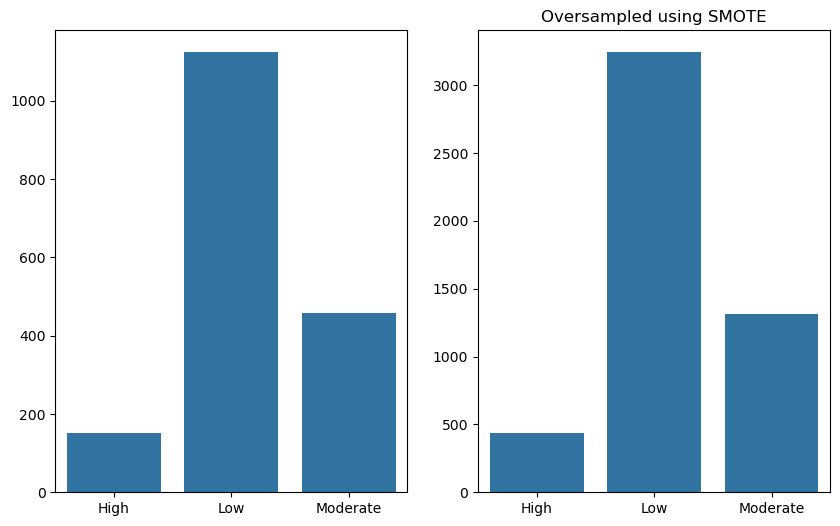

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
idx, c = np.unique(y, return_counts=True)
idx2, c2 = np.unique(y_res_2, return_counts=True)
sns.barplot(x=idx, y=c, ax=ax[0])
plt.title('Oversampled using SMOTE')
sns.barplot(x = idx2, y=c2, ax=ax[1])
plt.show()

In [28]:
# Split the proportional smoted data sets into train and test sets
X_train_smote_prop, X_test_smote_prop, y_train_smote_prop, y_test_smote_prop = train_test_split(X_res_2, y_res_2)

In [29]:
# View the different shapes of the training and test datasets
print(X_train_smote_prop.shape, X_test_smote_prop.shape, y_train_smote_prop.shape, y_test_smote_prop.shape)

#View the original training and test dataset shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3747, 10) (1250, 10) (3747,) (1250,)
(1299, 10) (434, 10) (1299,) (434,)


### Run a side-by-side comparison of different classifier models:

In [30]:
# Import models
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# The models dictionary should contain 5 models
models = {"LinearSVC": LinearSVC(dual=False),
          "KNeighborsClassifier": KNeighborsClassifier(),
          "SVC": SVC(),
          "LogisticRegression": LogisticRegression(),
          "RandomForestClassifier": RandomForestClassifier(class_weight='balanced')}

# Create an empty dictionary called results
results = {}

Loop through the models dictionary items, fitting the model on the training data 
and appending the model name and model score (accuracy) on the test data to the results dictionary.

In [31]:
np.random.seed(42)

for model_name, model in models.items():
    model.fit(X_train_smote_prop, y_train_smote_prop)
    results[model_name] = model.score(X_test_smote_prop, y_test_smote_prop)
    
results

{'LinearSVC': 0.6944,
 'KNeighborsClassifier': 0.864,
 'SVC': 0.7456,
 'LogisticRegression': 0.7104,
 'RandomForestClassifier': 0.8848}

Create a pandas dataframe with the data being the values of the results dictionary, the index as the keys of the results dictionary, and a single column called 'Accuracy.' Save the dataframe to a variable.

The most accurate model is: RandomForestClassifier()
                        Accuracy
LinearSVC                 0.6944
KNeighborsClassifier      0.8640
SVC                       0.7456
LogisticRegression        0.7104
RandomForestClassifier    0.8848


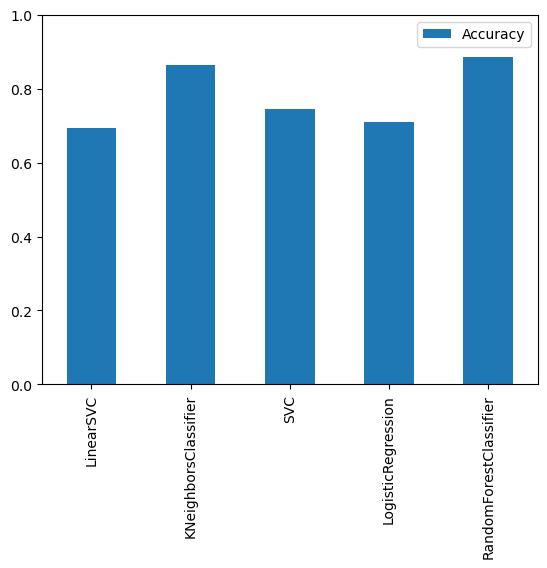

In [32]:
best_estimator = eval(max(results, key=results.get) + "()")
print("The most accurate model is: " + str(best_estimator))

results_df = pd.DataFrame(results.values(), 
                          results.keys(), 
                          columns=["Accuracy"])

print(results_df)

# Create a bar plot of the results dataframe using plot.bar()
ax = results_df.plot.bar()
plt.ylim(0.0, 1.0);

## Hyperparameter Tuning
Each classification model contains various parameters that can be tuned to improve the model's accuracy.

In [33]:
rfc = best_estimator

# List the parameters of the best estimator
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [34]:
# Import RandomizedSearchCV from sklearn's model_selection module
from sklearn.model_selection import RandomizedSearchCV

### RandomForestClassifier best parameter search

In [35]:
#Provide wide range of options for parameters for RandomForestClassifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


###  Linear SVC best parameter search

In [36]:
# Provide wide number of options for parameters for Linear SVC
#These are the parameters chosen to iterate through.

C = [0.001, 0.01, 0.1, 1, 10]
fit_intercept = [True, False]
class_weight = [None, 'balanced']
random_state = [42]

svc_grid = {'C' : C,
            'fit_intercept': fit_intercept,
            'class_weight': class_weight,
            'random_state': random_state}





###  kNN best parameter search

In [37]:
#provide wide number of options for parameters for kNN

n_neighbors = [x for x in range(3,10)]
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute', 'auto']
leaf_size = [x for x in range(10, 110, 10)]

knn_grid = {'n_neighbors': n_neighbors,
            'weights': weights,
            'algorithm': algorithm,
            'leaf_size': leaf_size}

### SVC best parameter search

In [38]:
#provide wide number of options for parameters for SVC

C = [0.001, 0.01, 0.1, 1, 10]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [x for x in range(3, 10)]
gamma = ['scale', 'auto']
class_weight = ['balanced', None]
random_state = [42]

svc_grid = {'C': C,
            'kernel': kernel,
            'degree': degree,
            'gamma': gamma,
            'class_weight': class_weight,
            'random_state': random_state}


### Logistic Regression best parameter search

In [39]:
#provide wide number of options for parameters for Logistic Regression

C = [0.001, 0.01, 0.1, 1, 10]
fit_intercept = [True, False]
class_weight = [None, 'balanced']
random_state = [42]
solver = ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']

logistic_grid = {'C': C,
                 'fit_intercept': fit_intercept,
                 'class_weight': class_weight,
                 'random_state': random_state,
                 'solver': solver}

In [40]:
param_grid = 0

print(type(best_estimator))
if str(best_estimator) == 'LogisticRegression()':
    param_grid = logistic_grid
elif str(best_estimator) == 'KNeighborsClassifier()':
    param_grid = knn_grid
elif str(best_estimator) == 'LinearSVC()':
    param_grid = linear_grid
elif str(best_estimator) == 'SVC()':
    param_grid = svc_grid
elif str(best_estimator) == 'RandomForestClassifier()':
    param_grid = random_grid


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


### Use the random grid to search for best hyperparameters

In [41]:
# First create the base model to tune
best_estimator = best_estimator
# Random search of parameters, using 3 fold cross validation; 
# search across 100 different combinations, and use all available cores
tuning = RandomizedSearchCV(estimator = best_estimator, param_distributions = param_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
search = tuning.fit(X_train_smote_prop, y_train_smote_prop)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  F

In [42]:
#show the best parameters found:
best_params = search.best_params_
best_params

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [43]:
#Evaluate these params compared to base params
# Import confusion_matrix and classification_report from sklearn's metrics module
from sklearn.metrics import confusion_matrix, classification_report

# Import precision_score, recall_score and f1_score from sklearn's metrics module
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Make predictions on test data with base model and store the predictions

In [44]:
rfc = RandomForestClassifier()
rfc.fit(X_train_smote_prop, y_train_smote_prop)
y_preds_smote_prop = rfc.predict(X_test)

In [45]:
# Create a confusion matrix using the confusion_matrix function
confusion_matrix(y_test, y_preds_smote_prop)

array([[ 41,   1,   2],
       [  2, 263,   0],
       [  2,  11, 112]], dtype=int64)

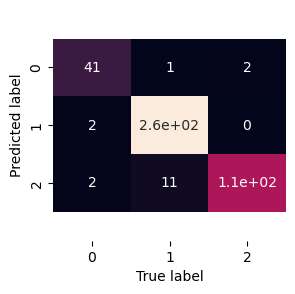

In [46]:
# Import seaborn for improving visualisation of confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make confusion matrix more visual
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
plot_conf_mat(y_test, y_preds_smote_prop)
plt.show()

In [47]:
# classification report
print(classification_report(y_test, y_preds_smote_prop))

              precision    recall  f1-score   support

        High       0.91      0.93      0.92        44
         Low       0.96      0.99      0.97       265
    Moderate       0.98      0.90      0.94       125

    accuracy                           0.96       434
   macro avg       0.95      0.94      0.94       434
weighted avg       0.96      0.96      0.96       434



Precision - Indicates the proportion of positive identifications (model predicted class 1) which were actually correct. A model which produces no false positives has a precision of 1.0.

Recall - Indicates the proportion of actual positives which were correctly classified. A model which produces no false negatives has a recall of 1.0.

F1 score - A combination of precision and recall. A perfect model achieves an F1 score of 1.0.

Support - The number of samples each metric was calculated on.

Accuracy - The accuracy of the model in decimal form. Perfect accuracy is equal to 1.0.

Macro avg - Short for macro average, the average precision, recall and F1 score between classes. Macro avg doesn’t class imbalance into effort, so if you do have class imbalances, pay attention to this metric.

Weighted avg - Short for weighted average, the weighted average precision, recall and F1 score between classes. Weighted means each metric is calculated with respect to how many samples there are in each class. This metric will favour the majority class (e.g. will give a high value when one class out performs another due to having more samples).


### Cross-Validation Score

In [48]:
# Import cross_val_score from sklearn's model_selection module
from sklearn.model_selection import cross_val_score

In [49]:
cross_val_score(rfc, 
                X_res_2, 
                y_res_2, 
                scoring="accuracy",
                cv=5)

array([0.852     , 0.866     , 0.91191191, 0.93893894, 0.92592593])

### Taking the mean of the returned values from cross_val_score gives a cross-validated version of the scoring metric.

In [50]:
cross_val_acc_rfc = np.mean(cross_val_score(rfc,
                                        X_res_2,
                                        y_res_2,
                                        scoring="accuracy",
                                        cv=5))

cross_val_acc_rfc

0.8981537537537537

In [51]:
best_params

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [52]:
#Evaluating model with tuned parameters:
rfc = RandomForestClassifier(n_estimators = 800,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            max_features = 'sqrt',
                            max_depth = 20,
                            bootstrap = False)

### Fit the tuned model on the SMOTEd datasets

In [53]:
rfc.fit(X_train_smote_prop, y_train_smote_prop)

RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=800)

### Measure accuracy of model and Log Loss

In [54]:
from sklearn.metrics import log_loss

#y test preds
y_test_preds = rfc.predict(X_test)

# Predict probabilities (for log loss)
y_test_prob = rfc.predict_proba(X_test)

# Calculate accuracy
val_acc = accuracy_score(y_test, y_test_preds)

# Calculate log loss
val_log_loss = log_loss(y_test, y_test_prob)

print(f"Validation Accuracy: {val_acc}")
print(f"Validation Log Loss: {val_log_loss}")

Validation Accuracy: 0.9654377880184332
Validation Log Loss: 0.08358249080849686


### Generate predictions

In [55]:
y_preds_smote_prop = rfc.predict(X_test)

In [56]:
# Create a confusion matrix using the confusion_matrix function
confusion_matrix(y_test, y_preds_smote_prop)

array([[ 41,   1,   2],
       [  0, 264,   1],
       [  2,   9, 114]], dtype=int64)

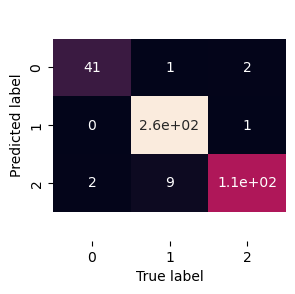

In [57]:
# Make confusion matrix more visual
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
plot_conf_mat(y_test, y_preds_smote_prop)
plt.show()

In [58]:
# New classification report
print(classification_report(y_test, y_preds_smote_prop))

              precision    recall  f1-score   support

        High       0.95      0.93      0.94        44
         Low       0.96      1.00      0.98       265
    Moderate       0.97      0.91      0.94       125

    accuracy                           0.97       434
   macro avg       0.96      0.95      0.95       434
weighted avg       0.97      0.97      0.97       434



In [59]:
# Taking the mean of the returned values from cross_val_score 
# gives a cross-validated version of the scoring metric.
cross_val_rfc = np.mean(cross_val_score(rfc,
                                        X_res_2,
                                        y_res_2,
                                        scoring="accuracy",
                                        cv=5))

cross_val_rfc

0.9203653653653653

In [60]:
#Improvement as a result of hyperparameter tuning
print('Improvement of {:0.2f}%.'.format( 100 * (cross_val_rfc - cross_val_acc_rfc) / cross_val_acc_rfc))

Improvement of 2.47%.


# Testing SMOTE model

In [61]:
exit_DI.head(20)

,CCAPSClientID,Distress_Index,Categories
1,643590,1.75000,Moderate
3,643635,1.20000,Low
5,643635,0.40000,Low
7,643635,0.00001,Low
9,643679,1.15000,Low
11,643679,1.00000,Low
13,643703,2.10000,Moderate
15,643784,2.05000,Moderate
17,643784,2.20000,Moderate
19,643841,1.50000,Moderate


In [62]:
#Manual Testing
exit_cats = pd.DataFrame(exit_DI['Categories'])
testing_df = pd.concat([ccaps_features, exit_cats.set_index(ccaps_features.index)], axis=1)
# testing_df = ccaps_features.insert(12, exit_DI['Categories'])
testing_df[40:46]

,CCAPSClientID,Date,Depression,Generalized_Anxiety,Social_Anxiety,Academic_Distress,Eating_Concerns,Frustration_Anger,Family_Distress,Substance_Use,Thoughts_of_Hurting_Others,Suicide_Index,Categories
124,656708,4/28/2022 0:00,2.000000,2.000000,3.142857,0.6,0.000000,0.428571,2.666667,0.0,0.0,1.0,Moderate
126,656708,12/6/2022 0:00,1.846154,2.777778,3.285714,0.8,0.000000,0.142857,2.333333,0.0,0.0,0.0,Moderate
128,656708,5/2/2023 0:00,2.153846,2.666667,3.714286,0.4,0.555556,0.142857,3.000000,0.0,0.0,0.0,Moderate
130,657604,8/26/2021 0:00,2.384615,1.111111,0.571429,1.8,0.111111,1.142857,0.833333,0.0,0.0,2.0,Low
132,657604,9/8/2022 0:00,1.846154,2.666667,0.000000,0.4,2.555556,0.285714,1.666667,0.5,0.0,2.0,Low
134,657627,8/26/2021 0:00,2.461538,3.111111,2.285714,1.6,3.222222,2.142857,2.166667,0.0,0.0,2.0,High


In [63]:
test1=rfc.predict([testing_df.iloc[0, 2:12]])
print(test1)

test2 = rfc.predict([testing_df.iloc[7, 2:12]])
print(test2)

test3 = rfc.predict([testing_df.iloc[9, 2:12]])
print(test3)

test4 = rfc.predict([testing_df.iloc[10, 2:12]])
print(test4)

test5 = rfc.predict([testing_df.iloc[45, 2:12]])
print(test5)

test6 = rfc.predict([testing_df.iloc[65, 2:12]])
print(test6)

test7_list = np.array([1.69, 2.33, 0.71, 1.8, 0, 1.71, 2, 0, 0, 0]).reshape(1, -1)
test7 = rfc.predict(test7_list)
print(test7)

['Moderate']
['Moderate']
['Moderate']


C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


['High']
['High']
['Low']
['Low']


C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [64]:
probabilities = rfc.predict_proba([testing_df.iloc[0, 2:12]])
probability = np.max(probabilities, axis=1)
probs = str(probability[0].round(2)*10e1) + "%"
probs

C:\Users\JCross\Desktop\CCAPS_ML\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


'81.0%'

# Feature Importance

### Which features contributed most to the outcome of the model and how did they contribute?

### Find the feature importance for this RandomForestClassifier Model.

In [65]:
#Check coef_
rfc.feature_importances_

array([0.16905333, 0.1559047 , 0.12296954, 0.12390866, 0.10729679,
       0.11548662, 0.10832878, 0.03671215, 0.01544008, 0.04489935])

In [66]:
# #Match coef's of features to columns
feature_dict =dict(zip(X.columns, list(rfc.feature_importances_)))
feature_dict

{'Depression': 0.16905332697692965,
 'Generalized_Anxiety': 0.1559047040636285,
 'Social_Anxiety': 0.12296953701306586,
 'Academic_Distress': 0.12390865903585609,
 'Eating_Concerns': 0.1072967922183883,
 'Frustration_Anger': 0.11548662120128013,
 'Family_Distress': 0.10832878158434892,
 'Substance_Use': 0.03671214555061376,
 'Thoughts_of_Hurting_Others': 0.015440082284476546,
 'Suicide_Index': 0.044899350071412186}

### This is telling us how much each of these features contributes to predicting the target variable.

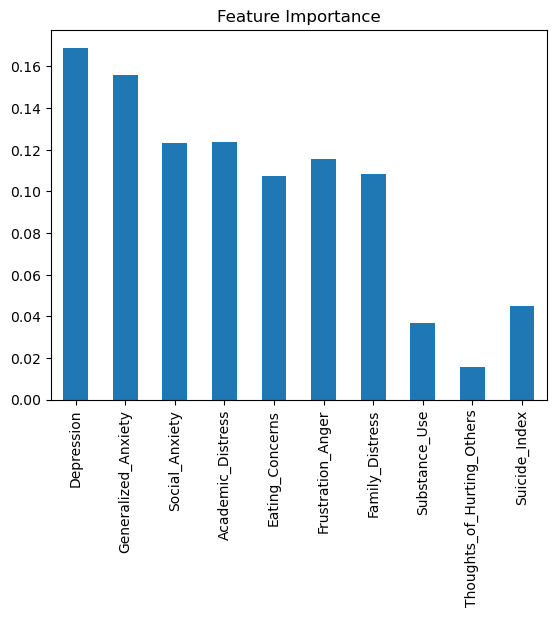

In [67]:
# #Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index = [0])
feature_df.T.plot.bar(title = 'Feature Importance', legend = False);

In [68]:
#further evaluation on a classification model
def evaluate_preds(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average = 'weighted')
    recall = recall_score(y_true, y_preds, average = 'weighted')
    f1 = f1_score(y_true, y_preds, average = 'weighted')
    metric_dict = { "accuracy": round(accuracy, 2),
                    "precision": round(precision, 2),
                    "recall": round(recall, 2),
                    "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}")
    print(f"Precision: {precision: .2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

# Exporting
###  If model meets evaluation metric (accuracy) goal for Low = .80, Medium = .80, High = .80, export to include in application.

In [69]:
#save and load the model using Joblib
from joblib import dump, load
# Save model to file
dump(rfc, filename="CCAPS_Outcomes_Prediction_ML_rfc.joblib")

['CCAPS_Outcomes_Prediction_ML_rfc.joblib']

In [70]:
#import the saved joblib model
loaded_job_model = load(filename = "CCAPS_Outcomes_Prediction_ML_rfc.joblib")

In [71]:
# Make and evaluate joblib predictions
joblib_y_preds = loaded_job_model.predict(X_test)
evaluate_preds(y_test, joblib_y_preds)

Acc: 96.54
Precision:  0.97
Recall: 0.97
F1 score: 0.97


{'accuracy': 0.97, 'precision': 0.97, 'recall': 0.97, 'f1': 0.97}

In [72]:
#classification report
print(classification_report(y_test, joblib_y_preds)) 

              precision    recall  f1-score   support

        High       0.95      0.93      0.94        44
         Low       0.96      1.00      0.98       265
    Moderate       0.97      0.91      0.94       125

    accuracy                           0.97       434
   macro avg       0.96      0.95      0.95       434
weighted avg       0.97      0.97      0.97       434



# Visualizing Accuracy

ROC curves are a comparison of a model's true positive rate (TPR) versus a model's false positive rate (FPR).

In [73]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve

In [74]:
#Find out what order the predict_proba method puts the classes in.  This will be important when plotting the roc curve
print(rfc.classes_)

#Run the prediction probabilities on X_test
pred_proba = rfc.predict_proba(X_test)
#print(f' This is pred_proba: {pred_proba}')

#Make the y_test labels binary due to multiclasses (ROC Curve was designed for binary classification)
binary_y = label_binarize(y_test, classes=['Low', 'Moderate', 'High'])
#print(f'This is the binary y: {binary_y}')

#Continue to binarize until you have three separate arrays of binary numbers for the classes
low_binary_y = binary_y[:, 0]
#print(f'This is low_binary_y: {low_binary_y}')
moderate_binary_y = binary_y[:, 1]
#print(f'This is the moderate_binary_y: {moderate_binary_y}')
high_binary_y = binary_y[:, 2]
#print(f'This is the high_binary_y: {high_binary_y}')

#Get the columns of the probability outputs for each class.  Remember the order they are in.
high_probs_pos = pred_proba[:, 0]
#print(f'This is the binary probs for the "High" classifier: {high_probs_pos[:10]}')

low_probs_pos = pred_proba[:, 1]
#print(f'This is the binary for the "Low" classifier: {low_probs_pos[:10]}')

moderate_probs_pos = pred_proba[:, 2]
#print(f'This is the binary for the "Moderate" classifier: {moderate_probs_pos[:10]}')

# #Get the FPR, TPR and threshold values
fpr_l, tpr_l, thresholds_l = roc_curve(low_binary_y, low_probs_pos)
fpr_m, tpr_m, thresholds_m = roc_curve(moderate_binary_y, moderate_probs_pos)
fpr_h, tpr_h, thresholds_h = roc_curve(high_binary_y, high_probs_pos)

['High' 'Low' 'Moderate']


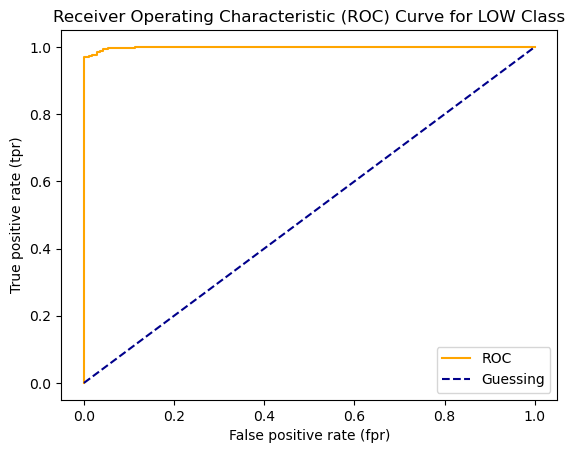

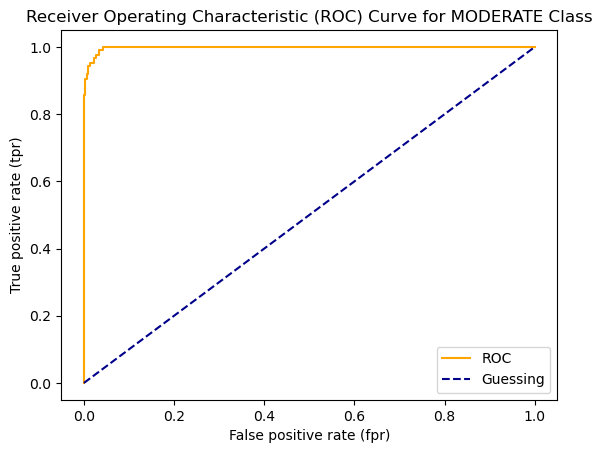

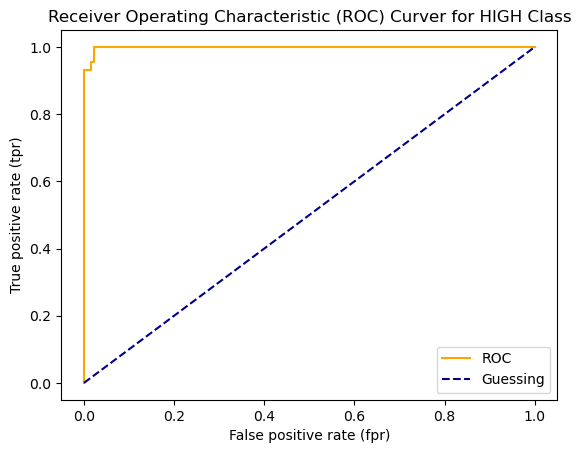

In [75]:
#Create a function for plotting ROC curves
def plot_roc_curve(fpr, tpr, title):
    """
    Plots a ROC curve given the false postitive rate (fpr) and trupe positive rate (tpr) of a model.
    """
        # Plot roc curve
    plt.plot(fpr, tpr, color = 'orange', label = "ROC")
    #Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label="Guessing")
    #Customize the plot
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr_l, tpr_l, 'Receiver Operating Characteristic (ROC) Curve for LOW Class')

plot_roc_curve(fpr_m, tpr_m, 'Receiver Operating Characteristic (ROC) Curve for MODERATE Class')

plot_roc_curve(fpr_h, tpr_h, 'Receiver Operating Characteristic (ROC) Curver for HIGH Class')

